最近更新有点慢，后台收到不少小伙伴的催更，先说声抱歉哈。最近在参加一个目标检测的比赛，时间比较紧张。这段时间我也打算调整一下思路，试着将目标检测中涉及的内容拆开来，将这些拆分的内容一点点融入到在后续的博客中。一方面兼具我现阶段的工作，一方面也不耽搁文章的更新进度。水到渠成后，就开始写目标检测方面的内容。

这篇文章中我放弃了以往的model.fit()训练方法，改用model.train_on_batch方法。两种方法的比较：

- `model.fit()`：用起来十分简单，对新手非常友好
- `model.train_on_batch()`：封装程度更低，可以玩更多花样。

此外我也引入了进度条的显示方式，更加方便我们及时查看模型训练过程中的情况，可以及时打印各项指标。

🔥本文 GitHub [https://github.com/kzbkzb/Python-AI](https://github.com/kzbkzb/Python-AI) 已收录

- 作者：[K同学啊](https://mp.weixin.qq.com/s/NES9RhtAhbX_jsmGua28dA)
- 来自专栏：《深度学习100例》-Tensorflow2版本
- 数据链接：https://pan.baidu.com/s/1qBmmV-bhm5b1KWey5Zc_rw （提取码：e5rq）

我的环境：

- 语言环境：Python3.6.5
- 编译器：jupyter notebook
- 深度学习环境：TensorFlow2.4.1

如果你是一名深度学习小白可以先看看我这个专门为你写的专栏：[《小白入门深度学习》](https://blog.csdn.net/qq_38251616/category_11188161.html)

# 一、前期工作

## 1. 设置GPU

如果使用的是CPU可以注释掉这部分的代码。

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)  #设置GPU显存用量按需使用
    tf.config.set_visible_devices([gpus[0]],"GPU")

# 打印显卡信息，确认GPU可用
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. 导入数据

In [2]:
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

import os,PIL

# 设置随机种子尽可能使结果可以重现
import numpy as np
np.random.seed(1)

# 设置随机种子尽可能使结果可以重现
import tensorflow as tf
tf.random.set_seed(1)

#隐藏警告
import warnings
warnings.filterwarnings('ignore')

import pathlib

In [3]:
data_dir = "./data/train"
# data_dir = "D:/jupyter notebook/DL-100-days/datasets/017_Eye_dataset"

data_dir = pathlib.Path(data_dir)

## 3. 查看数据

In [4]:
image_count = len(list(data_dir.glob('*/*')))

print("图片总数为：",image_count)

图片总数为： 3400


# 二、数据预处理

## 1. 加载数据

使用`image_dataset_from_directory`方法将磁盘中的数据加载到`tf.data.Dataset`中

In [5]:
batch_size = 8
img_height = 224
img_width = 224

TensorFlow版本是2.2.0的同学可能会遇到`module 'tensorflow.keras.preprocessing' has no attribute 'image_dataset_from_directory'`的报错，升级一下TensorFlow就OK了。

In [6]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3400 files belonging to 2 classes.
Using 2720 files for training.


In [7]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3400 files belonging to 2 classes.
Using 680 files for validation.


我们可以通过class_names输出数据集的标签。标签将按字母顺序对应于目录名称。

In [8]:
class_names = train_ds.class_names
print(class_names)

['cat', 'dog']


## 2. 再次检查数据 

In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(8, 224, 224, 3)
(8,)


- `Image_batch`是形状的张量（8, 224, 224, 3)。这是一批形状224x224x3的8张图片（最后一维指的是彩色通道RGB）。 
- `Label_batch`是形状（8，）的张量，这些标签对应8张图片

## 3. 配置数据集

- **shuffle()** ： 打乱数据，关于此函数的详细介绍可以参考：https://zhuanlan.zhihu.com/p/42417456
- **prefetch()** ：预取数据，加速运行，其详细介绍可以参考我前两篇文章，里面都有讲解。
- **cache()** ：将数据集缓存到内存当中，加速运行

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_image(image,label):
    return (image/255.0,label)

# 归一化处理
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
val_ds   = val_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

如果报 `AttributeError: module 'tensorflow._api.v2.data' has no attribute 'AUTOTUNE'` 错误，就将 `AUTOTUNE = tf.data.AUTOTUNE` 更换为 `AUTOTUNE = tf.data.experimental.AUTOTUNE`，这个错误是由于版本问题引起的。

## 4. 可视化数据

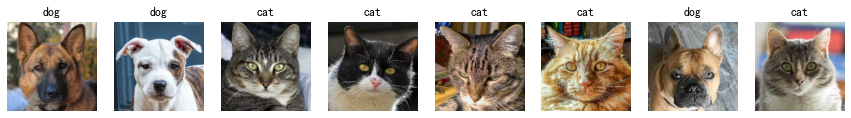

In [11]:
plt.figure(figsize=(15, 10))  # 图形的宽为15高为10

for images, labels in train_ds.take(1):
    for i in range(8):
        
        ax = plt.subplot(5, 8, i + 1) 
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        
        plt.axis("off")

# 三、构建VG-16网络

**VGG优缺点分析：**

- **VGG优点**

VGG的结构非常简洁，整个网络都使用了同样大小的卷积核尺寸（3x3）和最大池化尺寸（2x2）。

- **VGG缺点**

1)训练时间过长，调参难度大。2)需要的存储容量大，不利于部署。例如存储VGG-16权重值文件的大小为500多MB，不利于安装到嵌入式系统中。

**结构说明：**

- 13个卷积层（Convolutional Layer），分别用`blockX_convX`表示
- 3个全连接层（Fully connected Layer），分别用`fcX`与`predictions`表示
- 5个池化层（Pool layer），分别用`blockX_pool`表示

**`VGG-16`包含了16个隐藏层（13个卷积层和3个全连接层），故称为`VGG-16`**

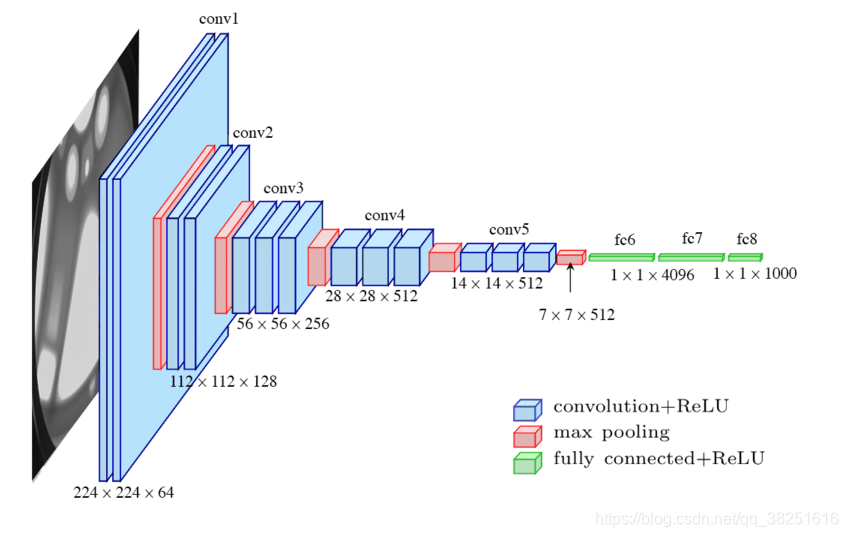

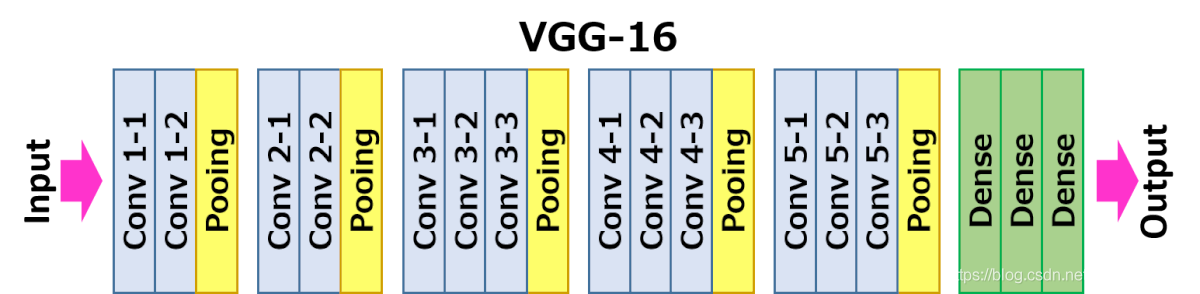

In [12]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

def VGG16(nb_classes, input_shape):
    input_tensor = Input(shape=input_shape)
    # 1st block
    x = Conv2D(64, (3,3), activation='relu', padding='same',name='block1_conv1')(input_tensor)
    x = Conv2D(64, (3,3), activation='relu', padding='same',name='block1_conv2')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'block1_pool')(x)
    # 2nd block
    x = Conv2D(128, (3,3), activation='relu', padding='same',name='block2_conv1')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same',name='block2_conv2')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'block2_pool')(x)
    # 3rd block
    x = Conv2D(256, (3,3), activation='relu', padding='same',name='block3_conv1')(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same',name='block3_conv2')(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same',name='block3_conv3')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'block3_pool')(x)
    # 4th block
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='block4_conv1')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='block4_conv2')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='block4_conv3')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'block4_pool')(x)
    # 5th block
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='block5_conv1')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='block5_conv2')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='block5_conv3')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'block5_pool')(x)
    # full connection
    x = Flatten()(x)
    x = Dense(4096, activation='relu',  name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    output_tensor = Dense(nb_classes, activation='softmax', name='predictions')(x)

    model = Model(input_tensor, output_tensor)
    return model

model=VGG16(1000, (img_width, img_height, 3))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# 四、编译

在准备对模型进行训练之前，还需要再对其进行一些设置。以下内容是在模型的编译步骤中添加的：

- 损失函数（loss）：用于衡量模型在训练期间的准确率。
- 优化器（optimizer）：决定模型如何根据其看到的数据和自身的损失函数进行更新。
- 评价函数（metrics）：用于监控训练和测试步骤。以下示例使用了准确率，即被正确分类的图像的比率。

In [13]:
model.compile(optimizer="adam",
              loss     ='sparse_categorical_crossentropy',
              metrics  =['accuracy'])

# 五、训练模型

In [14]:
from tqdm import tqdm
import tensorflow.keras.backend as K

epochs = 10
lr     = 1e-4

# 记录训练数据，方便后面的分析
history_train_loss     = []
history_train_accuracy = []
history_val_loss       = []
history_val_accuracy   = []

for epoch in range(epochs):
    train_total = len(train_ds)
    val_total   = len(val_ds)
    
    """
    total：预期的迭代数目
    ncols：控制进度条宽度
    mininterval：进度更新最小间隔，以秒为单位（默认值：0.1）
    """
    with tqdm(total=train_total, desc=f'Epoch {epoch + 1}/{epochs}',mininterval=1,ncols=100) as pbar:
        
        lr = lr*0.92
        K.set_value(model.optimizer.lr, lr)
        
        for image,label in train_ds:      
            """
            训练模型，简单理解train_on_batch就是：它是比model.fit()更高级的一个用法
            
            想详细了解 train_on_batch 的同学，
            可以看看我的这篇文章：https://mtyjkh.blog.csdn.net/article/details/119506151
            """
            history = model.train_on_batch(image,label)
            
            train_loss     = history[0]
            train_accuracy = history[1]
            
            pbar.set_postfix({"loss": "%.4f"%train_loss,
                              "accuracy":"%.4f"%train_accuracy,
                              "lr": K.get_value(model.optimizer.lr)})
            pbar.update(1)
        history_train_loss.append(train_loss)
        history_train_accuracy.append(train_accuracy)
            
    print('开始验证！')
    
    with tqdm(total=val_total, desc=f'Epoch {epoch + 1}/{epochs}',mininterval=0.3,ncols=100) as pbar:

        for image,label in val_ds:      
            
            history = model.test_on_batch(image,label)
            
            val_loss     = history[0]
            val_accuracy = history[1]
            
            pbar.set_postfix({"loss": "%.4f"%val_loss,
                              "accuracy":"%.4f"%val_accuracy})
            pbar.update(1)
        history_val_loss.append(val_loss)
        history_val_accuracy.append(val_accuracy)
            
    print('结束验证！')
    print("验证loss为：%.4f"%val_loss)
    print("验证准确率为：%.4f"%val_accuracy)

Epoch 1/10:   0%|                                                            | 0/85 [00:00<?, ?it/s]

开始验证！


Epoch 2/10:   1%|         | 2/340 [00:00<00:30, 11.02it/s, loss=0.5899, accuracy=0.8750, lr=8.46e-5]

结束验证！
验证loss为：0.9331
验证准确率为：0.6250


Epoch 2/10:   8%|█▊                    | 7/85 [00:00<00:02, 37.14it/s, loss=0.2198, accuracy=0.8750]

开始验证！


Epoch 3/10:   1%|         | 2/340 [00:00<00:30, 11.20it/s, loss=0.7195, accuracy=0.6250, lr=7.79e-5]

结束验证！
验证loss为：0.9926
验证准确率为：0.6250


Epoch 3/10:   8%|█▊                    | 7/85 [00:00<00:02, 37.74it/s, loss=0.0483, accuracy=1.0000]

开始验证！


Epoch 4/10:   1%|         | 2/340 [00:00<00:30, 11.27it/s, loss=0.0969, accuracy=1.0000, lr=7.16e-5]

结束验证！
验证loss为：0.4384
验证准确率为：0.8750


Epoch 4/10:   8%|█▊                    | 7/85 [00:00<00:02, 37.74it/s, loss=0.0547, accuracy=1.0000]

开始验证！


Epoch 5/10:   1%|         | 2/340 [00:00<00:30, 11.27it/s, loss=0.1939, accuracy=0.8750, lr=6.59e-5]

结束验证！
验证loss为：0.3161
验证准确率为：0.8750


Epoch 5/10:   8%|█▊                    | 7/85 [00:00<00:02, 36.94it/s, loss=0.0135, accuracy=1.0000]

开始验证！


Epoch 6/10:   0%|         | 1/340 [00:00<00:40,  8.29it/s, loss=0.1053, accuracy=0.8750, lr=6.06e-5]

结束验证！
验证loss为：0.1998
验证准确率为：0.8750


Epoch 6/10:   8%|█▊                    | 7/85 [00:00<00:02, 36.37it/s, loss=0.0160, accuracy=1.0000]

开始验证！


Epoch 7/10:   1%|         | 2/340 [00:00<00:30, 10.96it/s, loss=0.0074, accuracy=1.0000, lr=5.58e-5]

结束验证！
验证loss为：0.0695
验证准确率为：1.0000


Epoch 7/10:   8%|█▊                    | 7/85 [00:00<00:02, 37.14it/s, loss=0.0070, accuracy=1.0000]

开始验证！


Epoch 8/10:   1%|         | 2/340 [00:00<00:30, 11.14it/s, loss=0.0024, accuracy=1.0000, lr=5.13e-5]

结束验证！
验证loss为：0.0081
验证准确率为：1.0000


Epoch 8/10:   8%|█▊                    | 7/85 [00:00<00:02, 36.75it/s, loss=0.0023, accuracy=1.0000]

开始验证！


Epoch 9/10:   1%|         | 2/340 [00:00<00:30, 11.20it/s, loss=0.0056, accuracy=1.0000, lr=4.72e-5]

结束验证！
验证loss为：0.0400
验证准确率为：1.0000


Epoch 9/10:   8%|█▊                    | 7/85 [00:00<00:02, 36.75it/s, loss=0.0046, accuracy=1.0000]

开始验证！


Epoch 10/10:   1%|        | 2/340 [00:00<00:30, 11.02it/s, loss=0.0075, accuracy=1.0000, lr=4.34e-5]

结束验证！
验证loss为：0.0302
验证准确率为：1.0000


Epoch 10/10:   8%|█▋                   | 7/85 [00:00<00:02, 37.14it/s, loss=0.0000, accuracy=1.0000]

开始验证！


Epoch 10/10: 100%|████████████████████| 85/85 [00:02<00:00, 42.15it/s, loss=0.0231, accuracy=1.0000]

结束验证！
验证loss为：0.0231
验证准确率为：1.0000


In [15]:
# 这是我们之前的训练方法。
# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=epochs
# )

# 六、模型评估

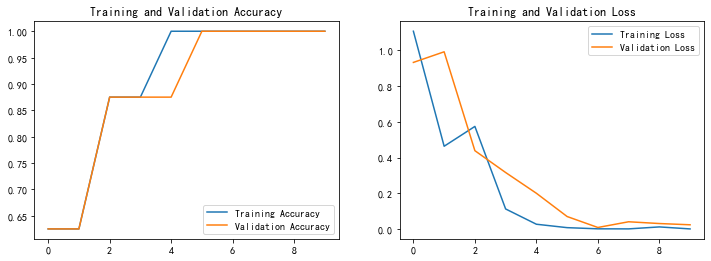

In [16]:
epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, history_train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, history_val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_train_loss, label='Training Loss')
plt.plot(epochs_range, history_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 七、保存and加载模型

这是最简单的模型保存与加载方法哈

In [17]:
# 保存模型
model.save('model/21_model.h5')

In [18]:
# 加载模型
new_model = tf.keras.models.load_model('model/21_model.h5')

# 八、预测

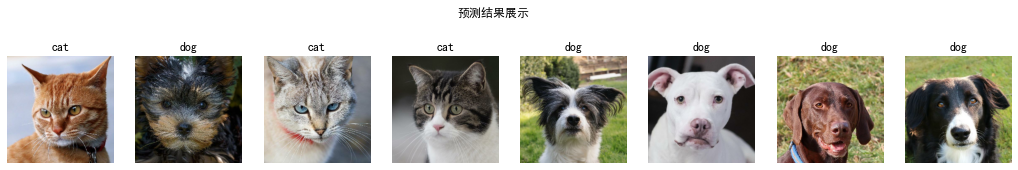

In [19]:
# 采用加载的模型（new_model）来看预测结果

plt.figure(figsize=(18, 3))  # 图形的宽为18高为5
plt.suptitle("预测结果展示")

for images, labels in val_ds.take(1):
    for i in range(8):
        ax = plt.subplot(1,8, i + 1)  
        
        # 显示图片
        plt.imshow(images[i].numpy())
        
        # 需要给图片增加一个维度
        img_array = tf.expand_dims(images[i], 0) 
        
        # 使用模型预测图片中的人物
        predictions = new_model.predict(img_array)
        plt.title(class_names[np.argmax(predictions)])

        plt.axis("off")